# Banking Transaction Analytics

This example demonstrates how to set up a streaming pipeline that processes a stream of banking transactions.

Each element in the stream contains the transaction id, customer id, transaction amount, credit/debit indicator, channel (ATM/Internet Banking/Branch) in JSON format.


In [ ]:
import apache_beam as beam
from apache_beam.runners.interactive import interactive_runner
import apache_beam.runners.interactive.interactive_beam as ib
from apache_beam.options import pipeline_options
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.io.gcp.internal.clients import bigquery
import google.auth
import json
import pandas as pd

In [ ]:
topic = "projects/project-name/topics/topic-name"

# So that Pandas Dataframes do not truncate data...
pd.set_option('display.max_colwidth', None)

In [ ]:
# Setting up the Beam pipeline options.
options = pipeline_options.PipelineOptions(flags={})

# Sets the pipeline mode to streaming, so we can stream the data from PubSub.
options.view_as(pipeline_options.StandardOptions).streaming = True

# Sets the project to the default project in your current Google Cloud environment.
# The project will be used for creating a subscription to the PubSub topic.
_, options.view_as(GoogleCloudOptions).project = google.auth.default()

## Recording Duration

We are working with unbounded sources. By default, *Apache Beam Notebooks* will record data from the unbounded sources for replayability. 
The following sets the data recording duration to 2 minutes (120 seconds).

In [ ]:
ib.options.recording_duration = '2m'

## Interactive Runner

* **Direct Runner** -> executes pipelines on your machine -> validation
* **Interactive Runner** -> iteratively develop pipelines, parse individual PCollections in a read-eval-print-loop (REPL) workflow
* **Dataflow runner** -> uploads your executable code and dependencies to a GCS bucket and creates a Cloud Dataflow job, which executes on managed resources

The following creates a pipeline with the *Interactive Runner* as the runner with the options we just created.

In [ ]:
p = beam.Pipeline(interactive_runner.InteractiveRunner(), options=options)

## Read transactions from Pub/Sub

The following creates a PTransform that will create a subscription to the given Pub/Sub topic and reads from the subscription. 

The data is in JSON format, so we add another Map PTransform to parse the data as JSON.

In [ ]:
data = p | "Read from Pub/Sub" >> beam.io.ReadFromPubSub(topic=topic) | beam.Map(json.loads) 

In [ ]:
ib.show(data)

## Windowing Scheme

Because we are reading from an unbounded source, we need to create a windowing scheme.

Choose below between 

A] sliding windows with a 10-second duration, with one second for each slide.

B] fixed windows of 10-second duration each

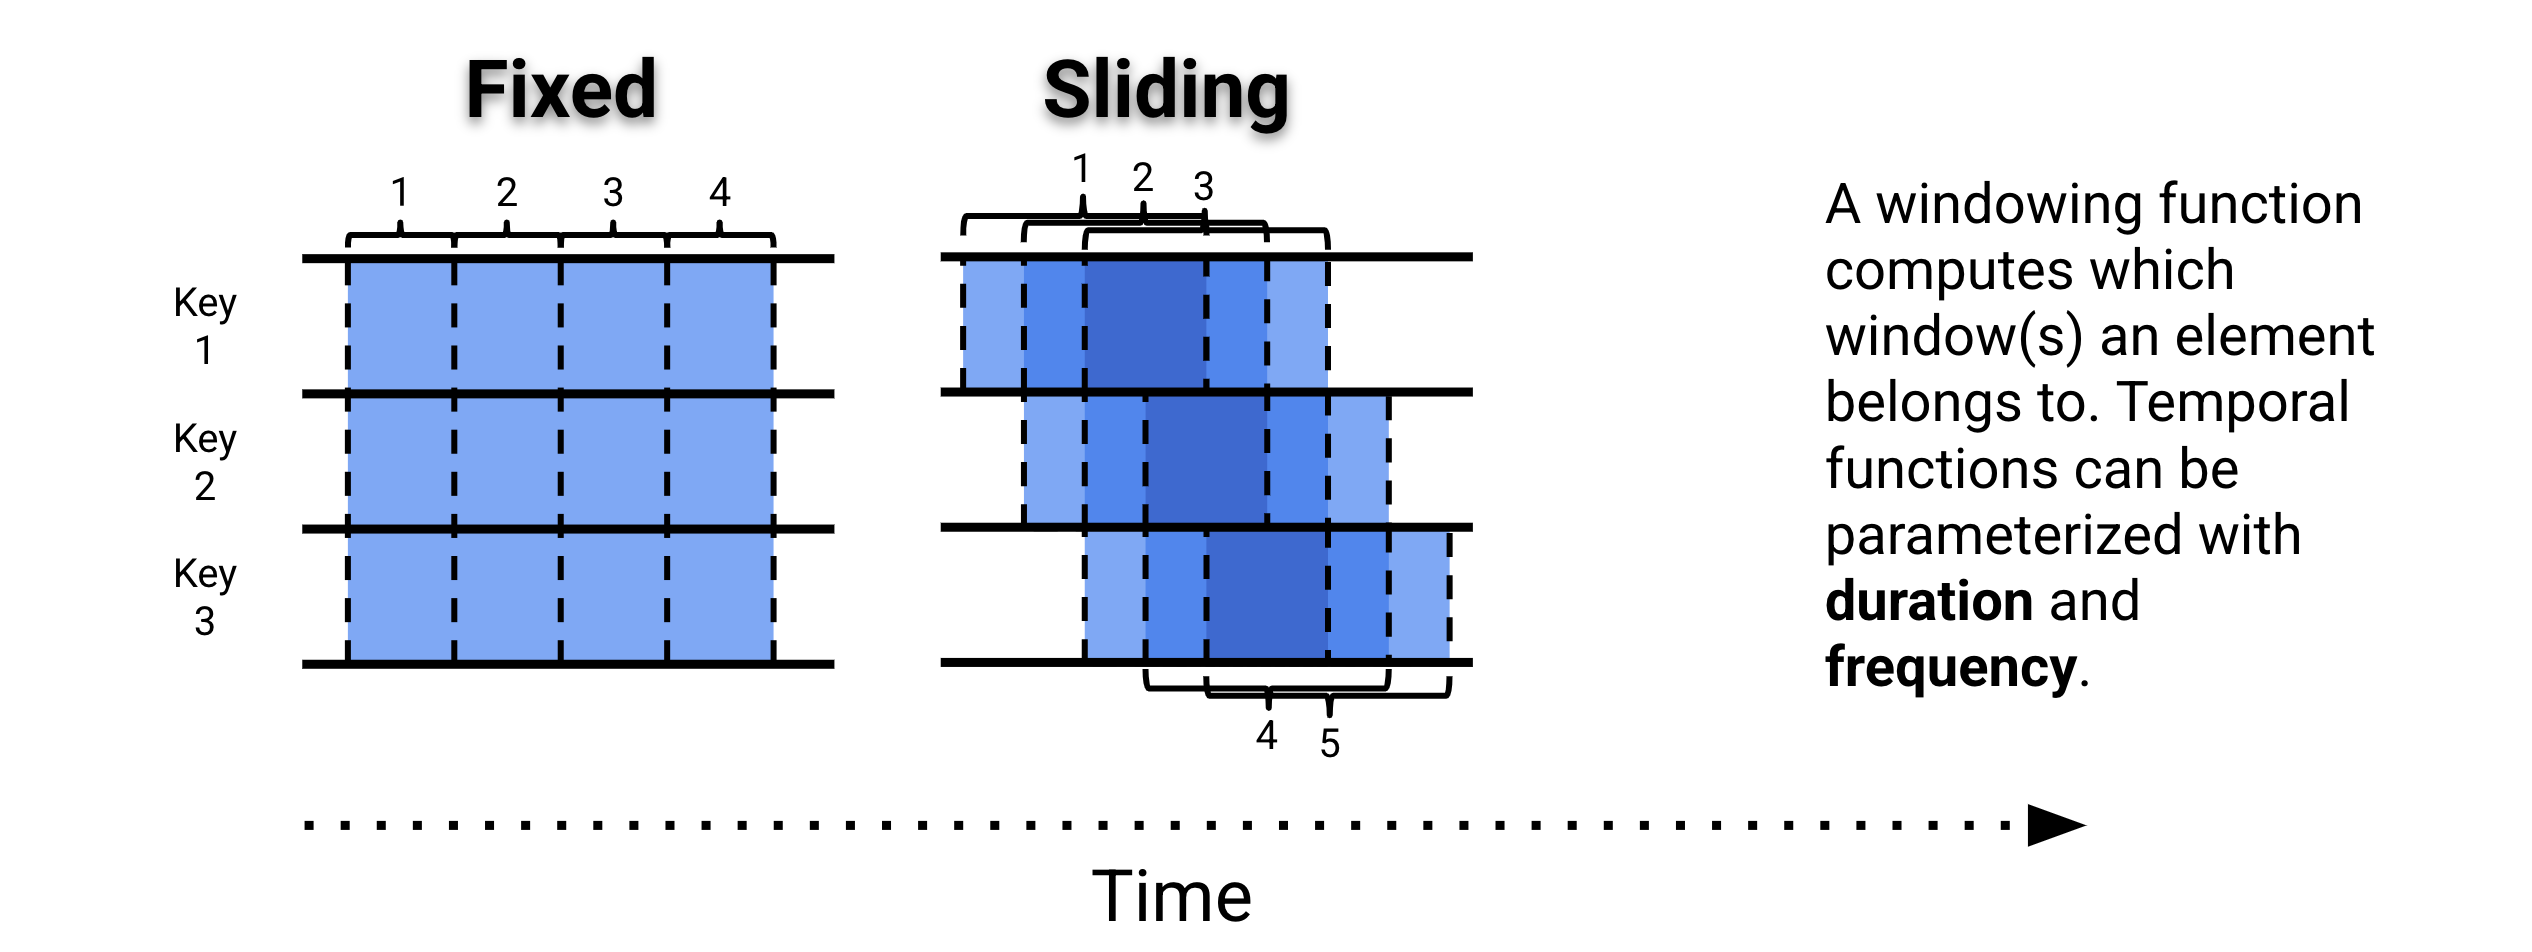

In [ ]:
#windowed_data = (data | "window" >> beam.WindowInto(beam.window.SlidingWindows(10, 1)))
windowed_data = (data | "Windows - 10 seconds" >> beam.WindowInto(beam.window.FixedWindows(10, 0)))

In [ ]:
ib.show(windowed_data, include_window_info=True, visualize_data=True)

## Calculate 10-second Run Rate

Now let's calculate the 10-second transaction value run rate for each second, by summing the `txn_amt` JSON field for each window.

First, extract the `txn_amt` field from the JSON object.

In [ ]:
txn_sum = windowed_data | "Get Txn Amts" >> beam.Map(lambda e: e.get('txn_amt'))

In [ ]:
run_rates = txn_sum | "Compute Run Rate" >> beam.CombineGlobally(sum).without_defaults()

In [ ]:
ib.show(run_rates, include_window_info=True)

In [ ]:
ib.collect(run_rates, include_window_info=True)

In [ ]:
import matplotlib.pyplot as plt
df=ib.collect(run_rates, include_window_info=True)
df.plot(y=0,kind="bar")

## Add a sink and run a Dataflow job

Now you can add a sink to run_rates, and run a Google Cloud Dataflow job, and you'll have a continuous run rate PubSub feed!

In [ ]:
table_spec = bigquery.TableReference(
    projectId='project-name',
    datasetId='dataset-name',
    tableId='table-name')

data | beam.io.WriteToBigQuery(
    table_spec,
#   schema=table_schema,
    write_disposition=beam.io.BigQueryDisposition.WRITE_APPEND,
    create_disposition=beam.io.BigQueryDisposition.CREATE_NEVER)

In [ ]:
#run_rates | "Write to PubSub" >> beam.io.WriteToPubSub(topic=outputtopic)

In [ ]:
from apache_beam.runners import DataflowRunner

In [ ]:
# Setting up the Beam pipeline options.
options = pipeline_options.PipelineOptions(flags={})

# Sets the pipeline mode to streaming, so we can stream the data from PubSub.
options.view_as(pipeline_options.StandardOptions).streaming = True

# Sets the project to the default project in your current Google Cloud environment.
# The project will be used for creating a subscription to the PubSub topic.
_, options.view_as(GoogleCloudOptions).project = google.auth.default()

options.view_as(GoogleCloudOptions).region = 'region-name'

# Choose a Cloud Storage location.
dataflow_gcs_location = 'gs://gcs-location'

# Set the staging location. This location is used to stage the
# Dataflow pipeline and SDK binary.
options.view_as(GoogleCloudOptions).staging_location = '%s/staging' % dataflow_gcs_location

# Set the temporary location. This location is used to store temporary files
# or intermediate results before outputting to the sink.
options.view_as(GoogleCloudOptions).temp_location = '%s/temp' % dataflow_gcs_location

In [ ]:
runner = DataflowRunner()
runner.run_pipeline(p, options=options)